C:\Users\EGYPT\AppData\Local\Temp\ipykernel_2084\2296316139.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\EGYPT\AppData\Local\Temp\ipykernel_2084\2296316139.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


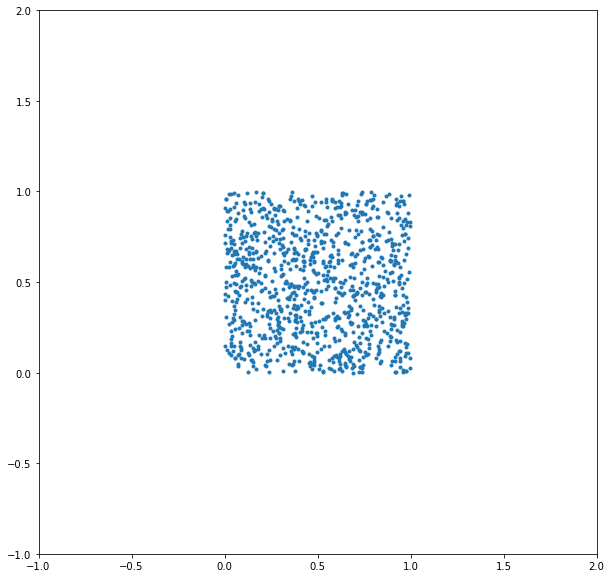

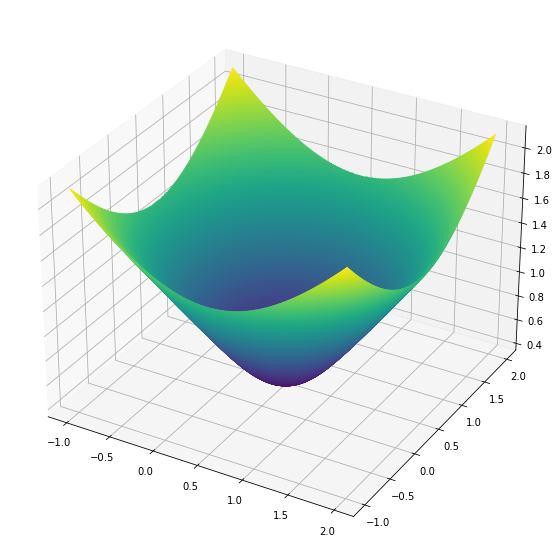

In [1]:
from random import Random
from math import sqrt 
from matplotlib.pyplot import figure

SEED = 5
generator = Random(SEED)

def gen_rand_pnts(N = 1000):
    return ([generator.uniform(a=0, b=1) for _ in range(N)]
            , [generator.uniform(a=0, b=1) for _ in range(N)])

data_x, data_y = gen_rand_pnts()
from matplotlib.pyplot import figure
fig = figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.scatter(x= data_x, y= data_y, marker=".")
ax.set_xlim(left=-1, right=2)
ax.set_ylim(top= 2, bottom=-1)
fig.show()

def loss(data_x, data_y, x_p, y_p):
    return(
        (1/len(data_x)) * sum(
        [sqrt( (x_i - x_p)**2 + (y_i - y_p)**2) for x_i, y_i in zip(data_x, data_y)]
    )
    )

def meshs(data_x , data_y ,step=0.01 , mesh_size=300):
    x_mesh = [-1+step*i for i in range(mesh_size)]
    y_mesh = [-1+step*i for i in range(mesh_size)]
    loss_mesh = [
        [loss(data_x, data_y , x, y) for y in y_mesh]
        for x in x_mesh 
    ]
    return x_mesh , y_mesh ,loss_mesh

fig = figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1,projection = "3d")
x_mesh , y_mesh ,loss_mesh = meshs(data_x, data_y)
ax.contour(x_mesh, y_mesh, loss_mesh, levels = 500)
fig.show()

0.48250436054723844 0.48250436054723844


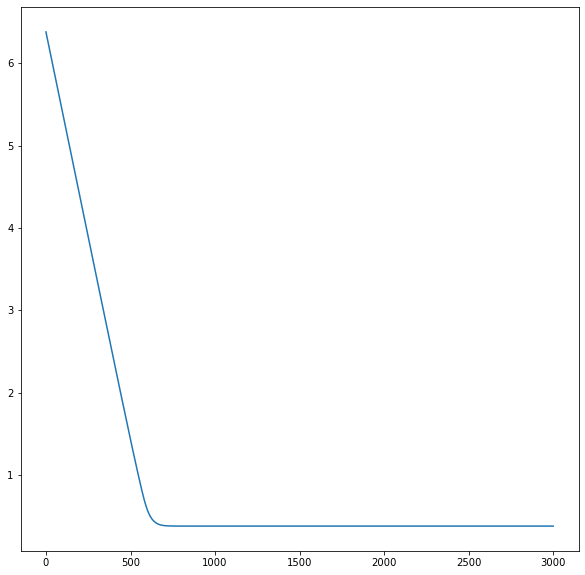

In [2]:
def grad(data_x, data_y, x_p, y_p, Epochs=3000, delta = 0.01, h=0.001):
    epochs_losses = []
    for _ in range(Epochs):
        epochs_losses.append(loss(data_x, data_y, x_p, y_p))
        dloss_dx = (1/h) * ((loss(data_x, data_y, x_p+h, y_p))-(loss(data_x, data_y, x_p, y_p)))
        dloss_dy = (1/h) * ((loss(data_x, data_y, x_p, y_p+h))-(loss(data_x, data_y, x_p, y_p)))
        x_p -= dloss_dx * delta
        y_p -= dloss_dx * delta
    fig = figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    ax.plot(epochs_losses)
    print(x_p , y_p) 
    
grad(data_x, data_y, 5, 5)

In [3]:
def grad_closed_form(data_x,data_y, xp, yp):
    sum_x, sum_y = 0,0
    c = (-1/len(data_x))
    for xi, yi in zip(data_x, data_y):
        inv_sqrt = ( (xi-xp)**2 + (yi-yp)**2 )**(-0.5)
        sum_x += inv_sqrt * (xi-xp)
        sum_y += inv_sqrt * (yi-yp)
    return sum_x * c , sum_y * c
print(grad_closed_form(data_x, data_y, 5,5))

(0.7063740168102004, 0.7063243377191615)


0.48326197196750886 0.49056261906862475


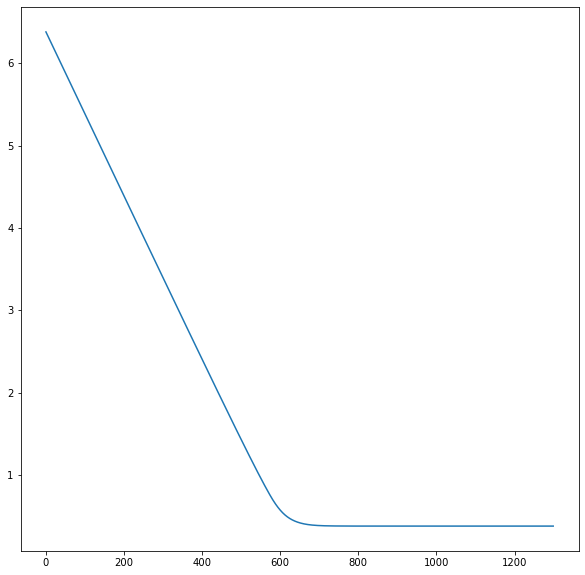

In [4]:
def optimize(data_x, data_y,x_p, y_p, epochs=1300, alpha=0.01):
    losses = []
    for _ in range(epochs):
        losses.append(loss(data_x, data_y, x_p, y_p))
        dloss_dx, dloss_dy = grad_closed_form(data_x, data_y, x_p, y_p)
        x_p -= dloss_dx * alpha
        y_p -= dloss_dy * alpha
    fig = figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    ax.plot(losses)
    print(x_p , y_p) 
optimize(data_x, data_y, 5,5)
        

In [5]:
from torch import (
    tensor,
    sum as torch_sum,
    rand,
    no_grad
)
from torch.random import manual_seed


In [6]:
gen = manual_seed(5)
data = rand(size=(1000, 2), generator=gen)
print(data, data.shape)

tensor([[0.8303, 0.1261],
        [0.9075, 0.8199],
        [0.9201, 0.1166],
        ...,
        [0.6178, 0.4808],
        [0.4608, 0.3819],
        [0.3918, 0.5023]]) torch.Size([1000, 2])


In [13]:
l = lambda pnt : torch_sum( torch_sum( (data-pnt)**2,dim=1)**.5)
pnt = tensor((5.,5.))#initially
pnt.requires_grad = True
for _ in range(30000):
    curr_loss = l(pnt)
    curr_loss.backward() # backprop
    with no_grad():
        pnt -= 0.001*pnt.grad.data #get the gradient calc
        pnt.grad.zero_()

print(pnt)

tensor([0.4627, 0.4744], requires_grad=True)


In [8]:
def stochastic_gradient(data_x , data_y , x_p, y_p, batch_size , epochs, delta):
    sampler = Random(x = 5)
    n = len(data_x)
    indices = [i for i in range(n)]
    num_batches = ceil(n/batch_size)
    losses = []
    for _ in range(epochs):
        sampler.shuffle(indices)
        for batch_index in range(num_batches):
            batch_indices = indices[batch_size*batch_index: 
                                   (batch_index+1)*batch_size]
            batch_x = [data_x[i] for i in batch_indices]
            batch_y = [data_y[i] for i in batch_indices]
            grad_x, grad_y = grad_closed_form(batch_x, batch_y, x_p, y_p)
            x_p -= delta * grad_x
            y_p -= delta * grad_y
            losses.append(loss(batch_x, batch_y, x_p, y_p))
    fig = figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    ax.plot(losses)
    print(x_p, y_p)



0.48286650566316647 0.4897698416807675


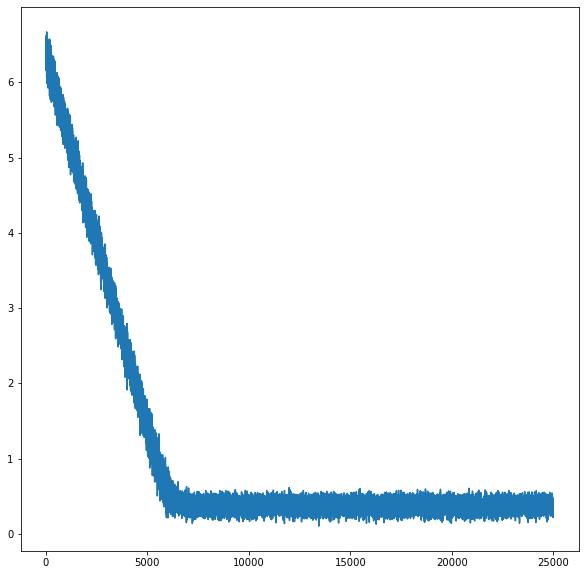

In [9]:
from math import ceil
stochastic_gradient(data_x, data_y , 5, 5, 4, 100, 0.001)

In [10]:
import torch
def loss_numerical(data_x, data_y , x_p , y_p):
    data = torch.tensor([data_x, data_y]).t()
    pnt = torch.tensor([x_p, y_p])
    res = data - pnt
    res = res**2
    res = res.sum(dim=1)
    res = torch.sqrt(res)
    res = res.sum(dim=0)
    res/= data.shape[0]
    return res
print(loss_numerical(data_x, data_y , 5,5))

tensor(6.3829)


In [11]:
from sklearn.datasets import make_moons
from math import floor
N = 1000
NOISE = 0.1
TRAIN_PERCENT = 0.8
x,y = make_moons(n_samples = N, shuffle = True, noise = NOISE, random_state = 5)
print(x.shape, y.shape)
#splitting the data into training and testing data
x_train, y_train = x[:floor(TRAIN_PERCENT*N),:],y[:floor(TRAIN_PERCENT*N)]
x_valid, y_valid = x[floor(TRAIN_PERCENT*N):,:],y[floor(TRAIN_PERCENT*N):]
print(x_valid.shape, y_valid.shape)

(1000, 2) (1000,)
(200, 2) (200,)


In [12]:
import torch
x_train, y_train = torch.tensor(x_train), torch.tensor(y_train)
x_valid, y_valid = torch.tensor(x_valid), torch.tensor(y_valid)
#print(x_valid.shape, type(x_valid))

# encode the targets using one hot which is a part of the .nn.functional submodule read the docs for more info
y_train = torch.nn.functional.one_hot(y_train, num_classes=2)
y_valid = torch.nn.functional.one_hot(y_valid, num_classes=2)

In [14]:
torch.manual_seed(5)
w = torch.randn(size=(2,2))
w = w.to(torch.float64)
w.requires_grad = True
w.retain_grad()

b = torch.randn(size=(1,2))
b = b.to(torch.float64)
b.requires_grad = True
b.retain_grad()

In [15]:
def predict(x):
    a = x @ w.T + b
    return torch.softmax(a , dim=1)

def loss_fn(x , y):
    y_hat = predict(x)
    return torch.mean(-(y*torch.log(y_hat)).sum(dim=1))

In [16]:
epochs = 1000 
train_loss , valid_loss = [], []
delta = 0.1

for _ in range(epochs):
    curr_train_loss = loss_fn(x_train, y_train)
    curr_train_loss.backward()
    train_loss.append(curr_train_loss.data)
    with torch.no_grad():
        curr_valid_loss = loss_fn(x_valid, y_valid)
        valid_loss.append(curr_valid_loss.data)
        w -= delta*w.grad.data
        b -= delta*b.grad.data
        w.grad.zero_()
        b.grad.zero_()
        
    

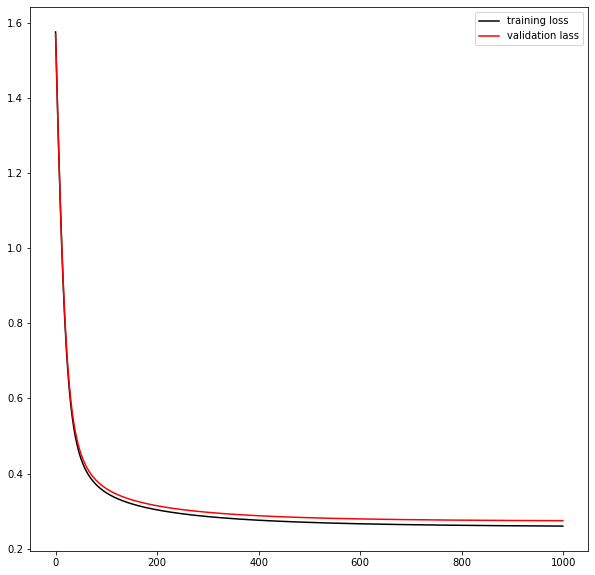

In [17]:
from matplotlib.pyplot import figure
fig1 = figure(figsize=(10,10))
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(train_loss, label="training loss", color="black")
ax1.plot(valid_loss, label="validation lass", color="red")
ax1.legend()

In [18]:
class comp_node:
    """
A computational node that represents a mathematical operation.

Attributes:
-----------
val : float
    The numerical value of the computational node.
children : list, optional
    A list of child nodes. Default is an empty list.
grad : float
    The gradient of the computational node with respect to a target variable.
op : str
    The type of operation performed by the node.
backward : function
    The function to compute the gradients of this node.

Methods:
--------
__init__(self, val, children=[], op="assign"):
    Initializes a computational node object.

__to_comp_node(self, obj):
    Converts a non-comp_node object to a comp_node object.

__sub__(self, other):
    Subtracts another computational node from this node.

__rsub__(self, other):
    Subtracts this node from another computational node.

__pow__(self, exponent):
    Raises this node to a power.

__eq__(self, other):
    Checks if this node is equal to another node.

__add__(self, other):
    Adds another computational node to this node.

__radd__(self, other):
    Adds this node to another computational node.

__mul__(self, other):
    Multiplies this node by another computational node.

__rmul__(self, other):
    Multiplies another computational node by this node.

__repr__(self):
    Returns a string representation of the computational node.
"""
    def __init__(self, val, children=[], op="assign"):
        """
        Initializes a computational node object.

        Parameters:
        -----------
        val : float
            The numerical value of the computational node.
        children : list, optional
             A list of child nodes. Default is an empty list.
        op : str, optional
            The type of operation performed by the node. Default is "assign".
        """
        self.val = val
        self.children = children
        self.grad = 0
        self.op = op
        self.backward = lambda : None

    def __to_comp_node(self, obj):
        """
        Converts a non-comp_node object to a comp_node object.

        Parameters:
        -----------
        obj : any
            The object to be converted.

        Returns:
        --------
        comp_node
            The converted object as a computational node.
        """
        if not isinstance(obj, comp_node):
            return comp_node(val = obj)
        return obj

    def __sub__(self, other):
        """
    Subtracts another computational node from this node.

    Parameters:
    -----------
    other : comp_node or float
        The node or value to be subtracted.

    Returns:
    --------
    comp_node
        A new computational node representing the subtraction operation.
    """
        """This defines the behavior of the - operator for comp_node objects, which represents subtraction. It creates a new comp_node object (out) with the appropriate values and sets its backward propagation function (_backward_prop) to compute the gradients of the current node and its dependency (other) with respect to the output node (out). It then returns the out node."""
        other = self.__to_comp_node(other)
        out = comp_node(val=self.val-other.val, children=[self, other],
                        op = "sub")
        #return self.val - other.val
        def _backward_prop():
            """The += operator is used to accumulate gradients during backpropagation.
            In automatic differentiation (autodiff), the gradients are computed using the chain rule of differentiation. Each node in a computation graph (represented by comp_node in this code) stores its gradient with respect to the output of the overall computation. During backpropagation, the gradient of the loss with respect to each intermediate node in the graph is computed and added to the node's gradient."""
            self.grad += out.grad * 1
            other.grad += out.grad * (-1)
        out.backward = _backward_prop
        return out
    def __rsub__(self, other):
        """This defines the behavior of the - operator when the comp_node object is on the right-hand side of the operator. It simply calls the regular subtraction method with the order of the operands reversed."""
        other = self.__to_comp_node(other)
        return other - self

    def __pow__(self, exponent):
        """This defines the behavior of the ** operator for comp_node objects, which represents exponentiation. It creates a new comp_node object (out) with the appropriate values and sets its backward propagation function (_backward_prop) to compute the gradient of the current node with respect to its dependency (self) and the output node (out). It then returns the out node."""
        if not isinstance(exponent, (int, float)):
            raise ValueError(" Unsupported Type")
        out = comp_node(val = self.val**exponent, children=[self],
                        op=f"power {exponent}")

        def _backward_prop():
            self.grad += out.grad * (exponent * self.val**(exponent - 1))
        out.backward = _backward_prop # use no parentheses
        return out

    def __eq__(self, other):
        """This defines the behavior of the == operator for comp_node objects, which simply checks if the values of the two nodes are equal."""
        return  self.val == other.val

    def __add__(self, other):
        other = self.__to_comp_node(other)
        out = comp_node(val=self.val+other.val, children=[self, other],
                        op = "add")
        def _backward_prop():
            self.grad += out.grad * 1
            other.grad += out.grad * 1
        out.backward = _backward_prop
        return out

    def __radd__(self, other):
        other = self.__to_comp_node(other)
        return other + self

    def __mul__(self, other):
        other = self.__to_comp_node(other)
        return comp_node(val = self.val * other.val , op = "mult",
                         children=[self, other])

    def __rmul__(self, other):
        other = self.__to_comp_node(other)
        return self * other

    def __repr__(self):
        return f"op : {self.op} | val : {self.val:0.4f} | " \
               f"children : {len(self.children)} | gradient : {self.grad}"

assert comp_node(val=5).val == 5 ," Assignment failed"
assert (comp_node(val=5) - comp_node(val=3)).val== 2
assert (comp_node(val=5) - 3).val == 2
assert (3 - comp_node(val=5)).val == -2
assert ((comp_node(val= 5))**2).val == 25
assert ((comp_node(val= 5))**2) == comp_node(val = 25)

assert (comp_node(val=5) + comp_node(val=3)).val== 8
assert (comp_node(val=5) + 3).val == 8
assert (3 + comp_node(val=5)).val == 8

assert (comp_node(val=5) * comp_node(val=3)).val== 15
assert (3 * comp_node(val=5)).val == 15

In [22]:
data_x, data_y = gen_rand_pnts(1)
print(f"data_x : {data_x}, data_y : {data_y}")
x_p, y_p = comp_node(val = 0.3), comp_node(val=0.3)
def loss_graph(x_p, y_p, data_x, data_y):
    I_x, I_y = x_p - data_x, y_p - data_y
    g_x, g_y = I_x ** 2, I_y ** 2
    M = g_x + g_y
    L = M ** 0.5
    return L , [L, M, g_x, g_y , I_x, I_y, x_p, y_p]
l , topological = loss_graph(x_p, y_p, data_x[0], data_y[0])
topological[0].grad = 1
#print(l)
for i, node in enumerate(topological):
    node.backward()
    print(i, node)


data_x : [0.25741257887865954], data_y : [0.4935604519625496]
0 op : power 0.5 | val : 0.1982 | children : 1 | gradient : 1
1 op : add | val : 0.0393 | children : 2 | gradient : 2.5228296704201654
2 op : power 2 | val : 0.0018 | children : 1 | gradient : 2.5228296704201654
3 op : power 2 | val : 0.0375 | children : 1 | gradient : 2.5228296704201654
4 op : sub | val : 0.0426 | children : 2 | gradient : 0.21488161918319224
5 op : sub | val : -0.1936 | children : 2 | gradient : -0.9766401024621146
6 op : assign | val : 0.3000 | children : 0 | gradient : 0.21488161918319224
7 op : assign | val : 0.3000 | children : 0 | gradient : -0.9766401024621146


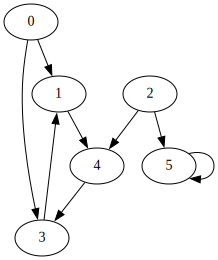

In [27]:
graph_1_vertices = set(range(8))
graph_1_edges = {
    0 : [1, 4],
    1 : [0, 5],
    2 : [5, 6],
    3 : [7],
    4 : [0],
    5 : [2, 6],
    6 : [2, 5, 7],
    7 : [3,6],
}

graph_2_vertices = set(range(6))
graph_2_edges = {
    0 : [1, 3],
    1 : [4],
    2 : [4, 5],
    3 : [1],
    4 : [3],
    5 : [5],
}

from graphviz import Digraph, Graph

def draw(vertices:set, edges:dict, directed:bool):
    """
    Takes in a set of vertices and a dictionary of edges and uses Graphviz to draw a visualization of the graph.

    Parameters:
    - vertices: a set of vertices in the graph
    - edges: a dictionary of edges in the graph, where each key is a vertex and the value is a list of adjacent vertices

    Returns:
    - a Graphviz Digraph object representing the visualization of the graph
    """
    global already_drawn
    if directed :
        dot = Digraph(format="svg")  # creates a new Digraph object with the SVG format
    else:
        dot = Graph(format='svg')
    for v in vertices:
        dot.node(name=str(v), label=f"{v}")  # adds a node to the graph for each vertex, with its label equal to its value
    if not directed:
        already_drawn = set()
    for k, v in edges.items():
        for curr_v in v:
            if directed:
                dot.edge(str(k), str(curr_v))  # adds an edge between each vertex and its adjacent vertices
            else:
                sorted_edge = tuple(sorted([k, curr_v]))
                if sorted_edge not in already_drawn:
                    already_drawn.add(sorted_edge)
                    dot.edge(str(k), str(curr_v))
    return dot  # returns the completed graph


graph_1 = draw(graph_2_vertices, graph_2_edges, True)
graph_1

In [23]:
def bfs(source:int, edges:dict, target=None, search=False):
    """A function that returns the breadth first traversal
    for each node in the graph that is reachable from the source node

    Parameters:
        source(int) : an integer representing the node to start traversal from
        edges(dict) : a dictionary where each key is a parent node and the values correspond to the childern
    """

    q = deque() # to keep track of the parent
    visited = set()
    q.append(source)
    visited.add(source)
    sort = [] #holds the bfs result

    while len(q) > 0 :
        curr = q.popleft()
        print(f"BFS visiting node {curr}")
        sort.append(curr)

        for child in edges[curr]:
            if child not in visited:
                q.append(child)
                visited.add(child)
    return sort

In [25]:
def dfs(source:int, vertices:list, edges:dict, visited=set(), topo=False):
    if visited is None:
        visited = set()
    try:
        visited.add(source)
        vertices.remove(source)
        print(f" dfs visiting node {source}")
        for child in edges[source]:
            if child not in visited:
                dfs(source=child, vertices = vertices, edges=edges, visited= visited)
        if len(vertices) != 0 :
            dfs(source = vertices[0], vertices=vertices, edges=edges, visited= visited)
    except Exception:
        pass


In [30]:
visited = set()
srt = []
def dfs(node):
    if node in visited:
        return
    visited.add(node)
    for neighbor in graph_2_edges[node]:
        dfs(neighbor)
    print(f" topological sort visiting {node}")
    srt.append(node)


for node in graph_2_vertices:
    if node not in visited:
        dfs(node)
print(f"\n a valid topological sort is {srt[::-1]}")

 topological sort visiting 3
 topological sort visiting 4
 topological sort visiting 1
 topological sort visiting 0
 topological sort visiting 5
 topological sort visiting 2

 a valid topological sort is [2, 5, 0, 1, 4, 3]
